<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_metalparameters_OptimizersAndLearningRate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

## Data

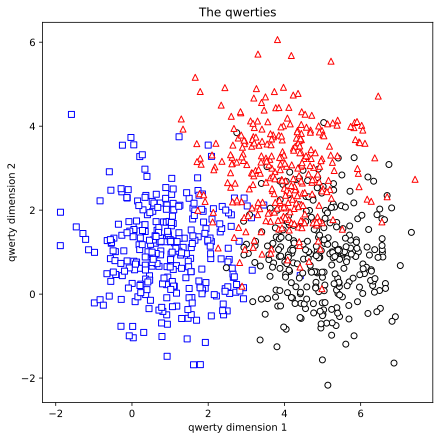

In [2]:
# create data
# create data 
nPerClust = 300
blur = 1

A = [1, 1]
B = [5, 1]
C = [4, 3]

# generate data
a = [A[0] + np.random.randn(nPerClust)*blur, A[1]+np.random.randn(nPerClust)*blur]
b = [B[0] + np.random.randn(nPerClust)*blur, B[1]+np.random.randn(nPerClust)*blur]
c = [C[0] + np.random.randn(nPerClust)*blur, C[1]+np.random.randn(nPerClust)*blur]

# true labels
labels_np = np.vstack((np.zeros((nPerClust, 1)), np.ones((nPerClust, 1)), np.ones((nPerClust, 1))+1))
# concatenate into a matrix
data_np = np.hstack((a, b, c)).T
# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.squeeze(torch.tensor(labels_np).long())

# show the data
fig = plt.figure(figsize=(7,7))
plt.plot(data[np.where(labels==0)[0], 0], data[np.where(labels==0)[0], 1], 'bs', markerfacecolor='w')
plt.plot(data[np.where(labels==1)[0], 0], data[np.where(labels==1)[0], 1], 'ko', markerfacecolor='w')
plt.plot(data[np.where(labels==2)[0], 0], data[np.where(labels==2)[0], 1], 'r^', markerfacecolor='w')
plt.title('The qwerties')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [3]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

# then convert into pytorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# finally, translate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

## MOdel

In [6]:
# create a class for the model
def createTheQwertyNet(optimizerAlgo, learning_rate):

    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            ### input layer
            self.input = nn.Linear(2, 8)

            ## hidden layer
            self.fc1 = nn.Linear(8, 8)

            ## output layer
            self.output = nn.Linear(8, 3)

        # forward pass
        def forward(self, x):

            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))

            return self.output(x)

    # create the model instance
    net = qwertyNet()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optifun = getattr(torch.optim, optimizerAlgo)
    optimizer = optifun(net.parameters(), lr=learning_rate)

    return net, lossfun, optimizer

In [7]:
# confirm that the optimizer has momentum
optim = createTheQwertyNet('Adam', .001)[2]
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

## Training

In [8]:
numepochs = 100

def function2trainTheModel(optimizerType, learning_rate):

    # create a new model
    net, lossfun, optimizer = createTheQwertyNet(optimizerType, learning_rate)

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):
        
        #switch to training mode
        net.train()


        batchLoss = []
        batchAcc = []
        # loop over batches
        for X, y in train_loader:

            #forward pass
            yHat = net(X)
            loss = lossfun(yHat, y)

            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y
            matchesNumeric = matches.float()
            accuracyPct = 100 * torch.mean(matchesNumeric)
            batchAcc.append(accuracyPct)

        # end of batch loop

        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        # compare the following really long line of code to the training accuracy lines
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))
    # end epochs

    # function outputs
    return trainAcc, testAcc, losses, net

            


## Time to experiments

In [15]:
# learning rate
learningRates = np.logspace(np.log10(0.0001), np.log10(0.1), 20)
trainAccResults = np.zeros((len(learningRates), 3))
testAccResults= np.zeros((len(learningRates), 3))
# trainAccuracyResults = 
for i, opto in enumerate(['SGD', 'RMSprop', 'Adam']):
    for j, learning_rate in enumerate(learningRates):
        trainAcc, testAcc, losses, net = function2trainTheModel(opto, learning_rate)

        # store the final results
        trainAccResults[j, i] = np.mean(trainAcc[-10:])
        testAccResults[j, i] = np.mean(testAcc[-10:])
    

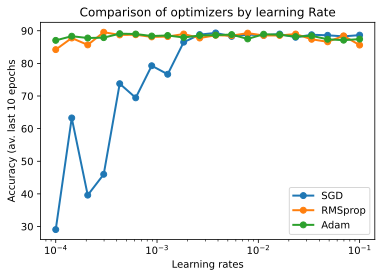

In [17]:
plt.plot(learningRates, testAccResults, 'o-', linewidth=2)
plt.legend(['SGD', 'RMSprop', 'Adam'])
plt.xscale('log')
plt.xlabel('Learning rates')
plt.ylabel('Accuracy (av. last 10 epochs')
plt.title('Comparison of optimizers by learning Rate')
plt.show()

### A function to plot the result

In [ ]:
# a function that plots the results
def plotTheResults(optimizerType):

    # compute accuracy over entire dataset (train + test)
    yHat = net(data)
    predictions = torch.argmax(yHat, axis=1)
    accuracy = (predictions == labels).float()
    totalAcc = torch.mean(100 * accuracy).item()


    # and accuracy by group
    accuracyByGroup = np.zeros(3)
    for i in range(3):
        accuracyByGroup[i] = 100*torch.mean(accuracy[labels==i])


    # create the figure
    fig, ax = plt.subplots(2, 2, figsize=(10, 6))

    # plot the loss function
    ax[0, 0].plot(losses.detach())
    ax[0, 0].set_ylabel('Loss')
    ax[0, 0].set_xlabel('Epochs')
    ax[0, 0].set_title(f'{optimizerType}: Losses')

    # plot the accuracy functions
    ax[0, 1].plot(trainAcc, label='Train')
    ax[0, 1].plot(testAcc, label='Test')
    ax[0, 1].set_title(f'{optimizerType}: Accuracy')
    ax[0, 1].set_xlabel('Epoch')
    ax[0, 1].set_ylabel('Accuracy (%)')
    ax[0, 1].legend()

    # plot overall accuracy by group
    ax[1, 0].bar(range(3), accuracyByGroup)
    ax[1, 0].set_ylim([np.min(accuracyByGroup) - 5, np.max(accuracyByGroup) + 5])
    ax[1, 0].set_xticks([0, 1, 2])
    ax[1, 0].set_xlabel('Group')
    ax[1, 0].set_ylabel('Accuracy (%)')
    ax[1, 0].set_title(f'{optimizerType}: Accuracy by group')

    # scatterplot of correct and incorect labeled data
    colorShapes = ['bs', 'ko', 'g^'] # data markers
    for i in range(3):
        # plot all data points
        ax[1, 1].plot(data[labels==i, 0], data[labels==i, 1], colorShapes[i], alpha=.3, label=f'Group {i}')

        # cross-out the incorrect ones
        idxErr = (accuracy == 0) & (labels == i)
        ax[1, 1].plot(data[idxErr, 0], data[idxErr, 1], 'rx')

    ax[1, 1].set_title(f'{optimizerType}: Total accuracy: {totalAcc:.2f}%')
    ax[1, 1].set_xlabel('qwerty dimension 1')
    ax[1, 1].set_ylabel('qwerty dimention 2')
    ax[1, 1].legend()

    plt.tight_layout()
    plt.show()


## Now for the experiment!

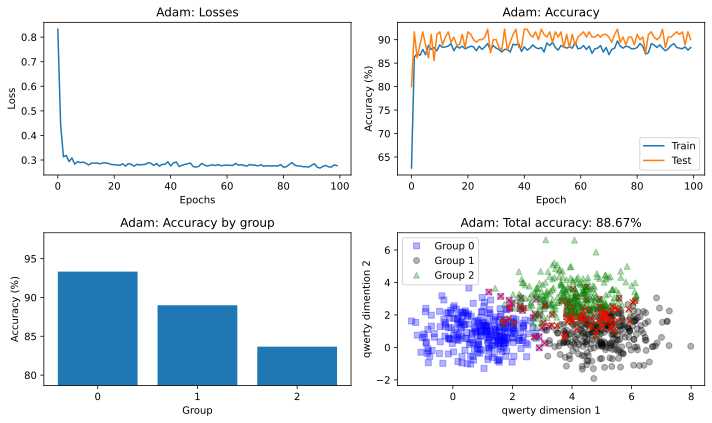

In [ ]:
# run the model for one optimizer
optimizerType = 'Adam'
trainAcc, testAcc, losses, net = function2trainTheModel(optimizerType)

# visualize!
plotTheResults(optimizerType)

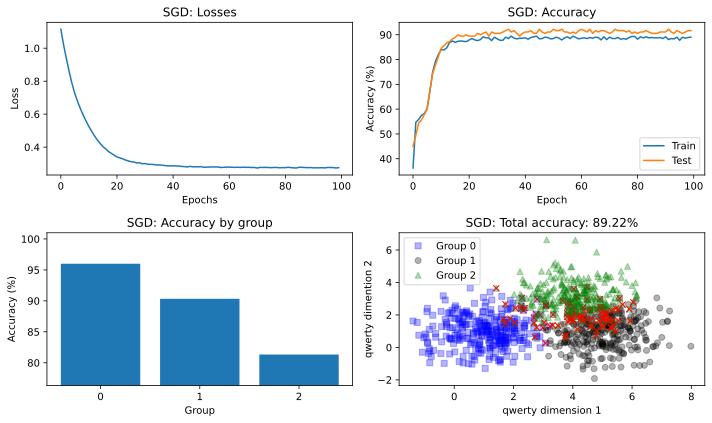

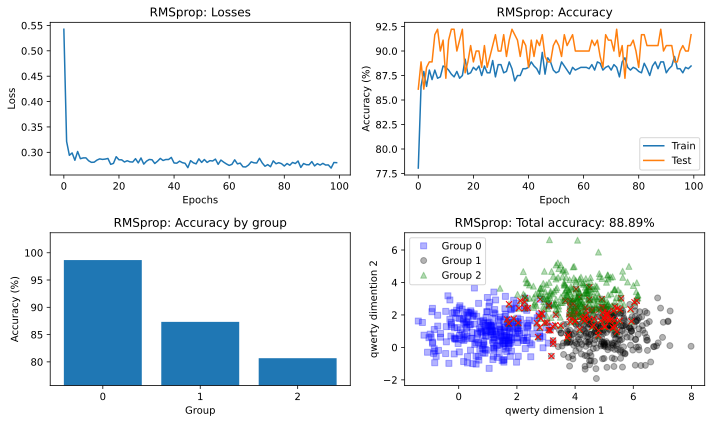

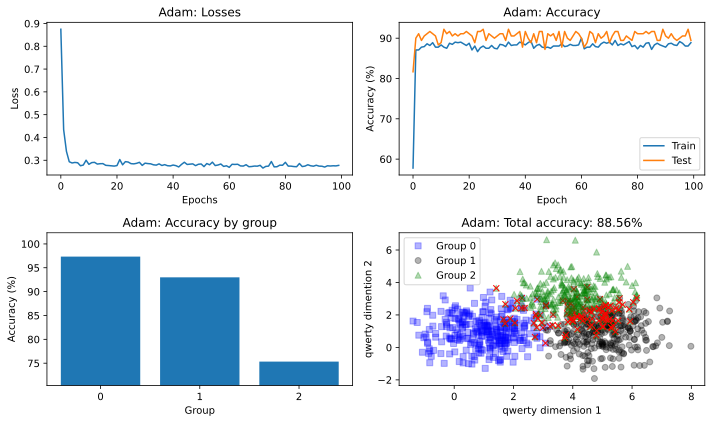

In [ ]:
# now run through all of them

# average performance
performance = []

for opto in ['SGD', 'RMSprop', 'Adam']:
    trainAcc, testAcc, losses, net = function2trainTheModel(opto)
    plotTheResults(opto)

    # store the final results
    train = np.mean(trainAcc[-10:])
    test = np.mean(testAcc[-10:])

    performance.append(f'{opto}: train {train: .1f}%, test {test: .1f}%')

In [ ]:
performance

['SGD: train  88.6%, test  91.3%',
 'RMSprop: train  88.3%, test  90.2%',
 'Adam: train  88.5%, test  90.4%']